# DataMole Air Pressure Assignment
Working on air pump failures
- Since we are predicting pump failures this is a classification problem. 
- First lets load and look at the data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pq_raw_data = pq.read_table('data/data.parquet')

In [3]:
df = pq_raw_data.to_pandas()

In [4]:
df.head(5)

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


In [6]:
print(f'Machine ID null sum: {df.MachineId.isnull().sum()}')
print(f'Measurement ID null sum: {df.MeasurementId.isnull().sum()}')
print(f'Pressure null sum: {df.Pressure.isnull().sum()}')

Machine ID null sum: 0
Measurement ID null sum: 0
Pressure null sum: 0


In [7]:
df.Pressure.describe()

count    1.846636e+07
mean     3.338926e-01
std      4.862787e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.017707e-01
max      6.774464e+00
Name: Pressure, dtype: float64

In [8]:
# First lets merge the machine id and measurement id columns to iterate over
df['cycle_code'] = df['MachineId'] + '_' + df['MeasurementId'].astype(str)

In [9]:
df.head()

,MachineId,MeasurementId,Pressure,cycle_code
0,0_0_0,0,0.0,0_0_0_0
1,0_0_0,0,0.0,0_0_0_0
2,0_0_0,0,0.0,0_0_0_0
3,0_0_0,0,0.0,0_0_0_0
4,0_0_0,0,0.0,0_0_0_0


So there are many 0 values, which could be from before the machine begins its cycle. The mean is 0.334. There could be some outliers in the max values as the max value is much larger than the 75% value.

In [10]:
labels = pd.read_csv('data/labels.csv')

In [11]:
labels.head(10)

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN
5,0_1_1,1,True,False,False
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
8,1_0_0,2,False,True,False
9,1_0_1,-1,NaN,NaN,NaN


There are some nan values which we will deal with later

In [12]:
labels['cycle_code'] = labels['MachineId'] + '_' + labels['MeasurementId'].astype(str)

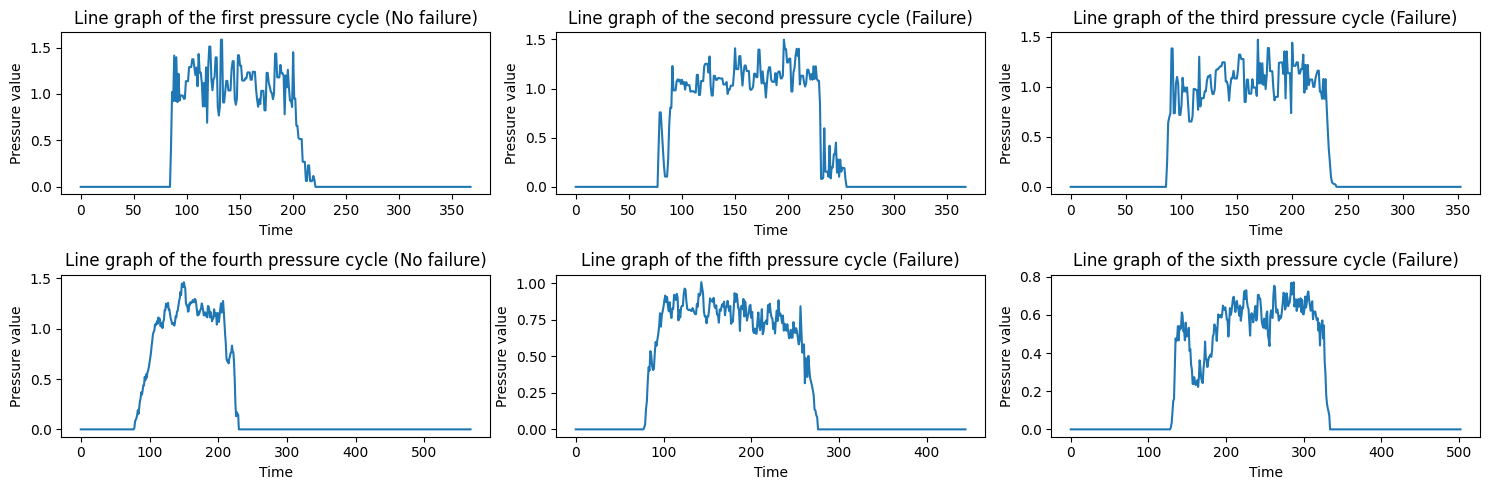

In [13]:
# Create a figure and six subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = df[(df['cycle_code'] == '0_0_0_0')]
axes[0, 0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0, 0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Pressure value')

# Access the second subplot
second_cycle = df[(df['cycle_code'] == '0_0_3_0')]
axes[0, 1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[0, 1].set_title('Line graph of the second pressure cycle (Failure)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Pressure value')

# Access the third subplot
third_cycle = df[(df['cycle_code'] == '0_1_1_1')]
axes[0, 2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[0, 2].set_title('Line graph of the third pressure cycle (Failure)')
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Pressure value')

# Access the fourth subplot
four_cycle = df[(df['cycle_code'] == '1_0_0_2')]
axes[1, 0].plot(range(len(four_cycle)), four_cycle['Pressure'])
axes[1, 0].set_title('Line graph of the fourth pressure cycle (No failure)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Pressure value')

# Access the fifth subplot
five_cycle = df[(df['cycle_code'] == '1_2_2_4')]
axes[1, 1].plot(range(len(five_cycle)), five_cycle['Pressure'])
axes[1, 1].set_title('Line graph of the fifth pressure cycle (Failure)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Pressure value')

# Access the sixth subplot
six_cycle = df[(df['cycle_code'] == '2_2_2_3')]
axes[1, 2].plot(range(len(six_cycle)), six_cycle['Pressure'])
axes[1, 2].set_title('Line graph of the sixth pressure cycle (Failure)')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

The pressure values look sorted. 
There are many zeros at the beginning and end of the machine cycle. A large drop at the beginning of the cycle indicates a failure. Lets delete the leading and trailing zeros

In [14]:
def del_lead_trail_zeros(cycle):
    # Find the indices of non-zero values
    non_zero_indices = cycle.index[cycle['Pressure'] != 0]

    if len(non_zero_indices) > 0:
        # Find the first and last non-zero indices
        start_index = non_zero_indices[0]
        end_index = non_zero_indices[-1]

        # Slice the DataFrame to keep all values between the first and last non-zero values
        mach_cycle = cycle.loc[start_index:end_index + 1]

        return mach_cycle
    else:
        # If there are no non-zero values, return an empty DataFrame
        return pd.DataFrame(columns=cycle.columns)

In [15]:
df_cleaned = df.groupby('cycle_code', group_keys=False).apply(del_lead_trail_zeros)

C:\Users\mslam\AppData\Local\Temp\ipykernel_34980\420724946.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cleaned = df.groupby('cycle_code', group_keys=False).apply(del_lead_trail_zeros)


In [18]:
df['MachineId'] = df['MachineId'].astype('category')
df['MeasurementId'] = df['MeasurementId'].astype('category')
df['Pressure'] = df['Pressure'].astype('float32')

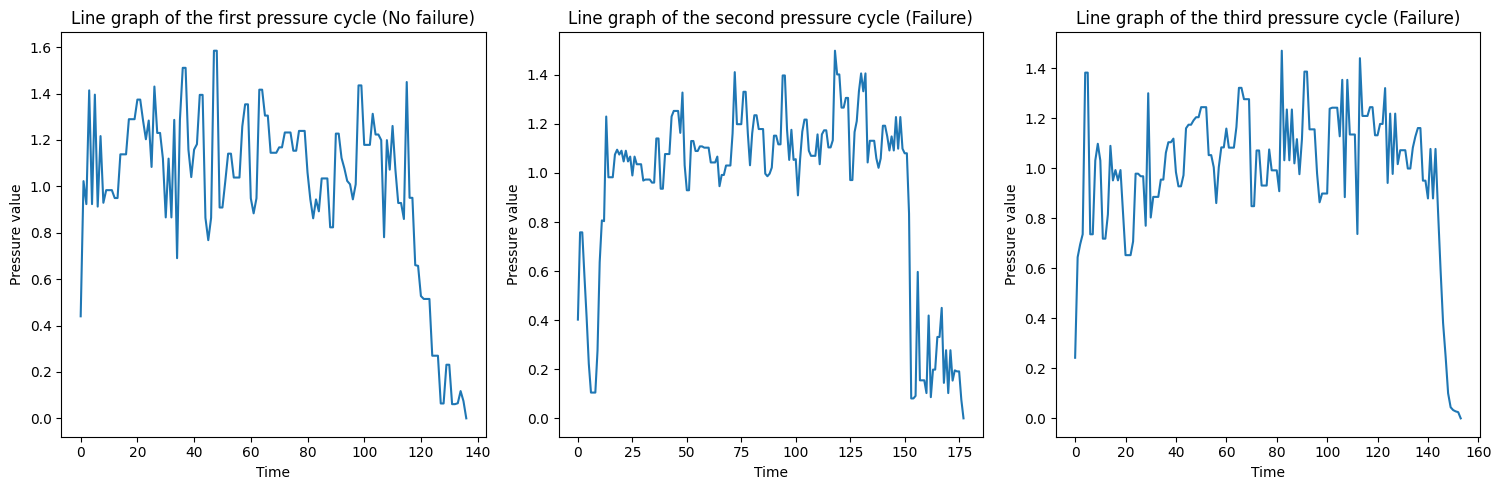

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = df_cleaned[(df_cleaned['cycle_code'] == '0_0_0_0')]
axes[0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Pressure value')

second_cycle = df_cleaned[(df_cleaned['cycle_code'] == '0_0_3_0')]
axes[1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[1].set_title('Line graph of the second pressure cycle (Failure)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Pressure value')

third_cycle = df_cleaned[(df_cleaned['cycle_code'] == '0_1_1_1')]
axes[2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[2].set_title('Line graph of the third pressure cycle (Failure)')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

That is looking much better, the leading and trialing zeros have been deleted.

In [20]:
#Lets see how many pressure values are measured per cycle, as there could be some 
# measurements that carried on for a long time (as in were left running)
pres_count = df_cleaned.groupby('cycle_code')['Pressure'].count().reset_index()
pres_count.columns = ['cycle_code', 'pressure_count']

In [21]:
pres_count.pressure_count.describe()

count     27311.000000
mean        389.930687
std        3642.889256
min           2.000000
25%         143.000000
50%         188.000000
75%         251.000000
max      183492.000000
Name: pressure_count, dtype: float64

Something weird is happening here. It seems that many of the pressure cycles are still long even after deleting the zeros. The pressure gauge could have been left on and therefore the leading and trialing zero function failed to delete the counts. So we can delete the cycles will over 350 pressure measurements. If we knew more about how often the pressure measurements were recorded we could do this step better. 

In [22]:
count = df_cleaned.groupby('cycle_code')['Pressure'].count().reset_index()
count.columns = ['cycle_code', 'pressure_count']
high_cycle = count.loc[count['pressure_count'] > 350, 'cycle_code']
pressure_count_filtered = count[~count['cycle_code'].isin(high_cycle)]
#Creating a new df without the cycles that are over 300 measurements long.
df_filtered = df_cleaned[~df_cleaned['cycle_code'].isin(high_cycle)]
#Also delete the rows from the labels df
labels = labels[~labels['cycle_code'].isin(high_cycle)]

In [23]:
new_count = df_filtered.groupby('cycle_code')['Pressure'].count().reset_index()
new_count.columns = ['cycle_code', 'pressure_count']

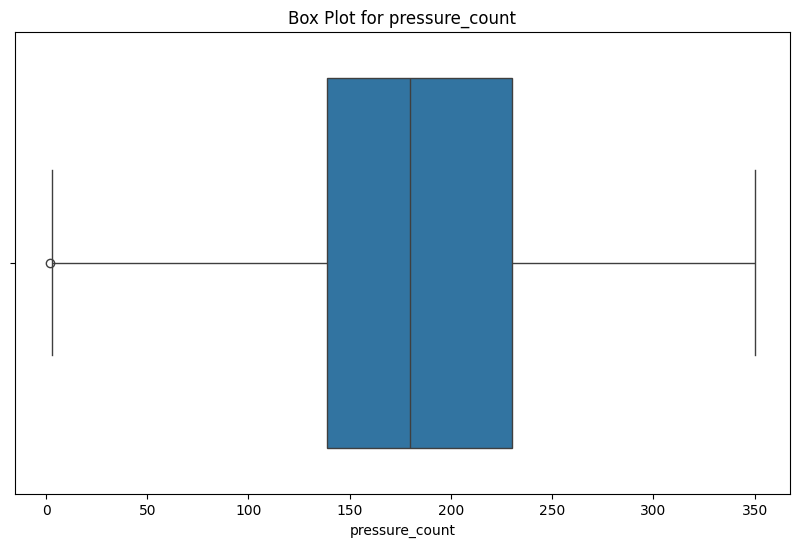

In [24]:
# Plot a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pressure_count', data=new_count)
plt.title('Box Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

That looks like a much better distribution with the outliers reduced. we will use a Random Forest Clasifier to get a baseline score, this model can also provide us with how well each variable predicts failure. We wont use SVM as it will take a long time to run. This is a binary classification problem. We will delete the cycle_codes, machine id and measurement id as they could be considered data leakage and will not carry valuable information when the model is applied to another set of machines. Next we need to deal with missing data. 

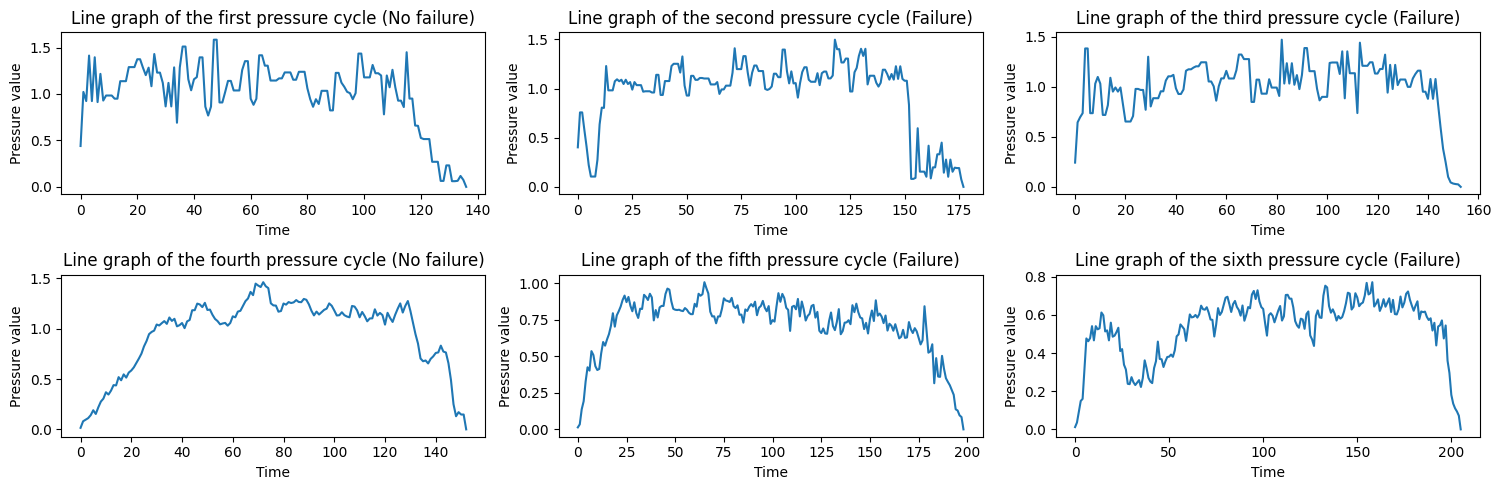

In [25]:
# Create a figure and six subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = df_filtered[(df_filtered['cycle_code'] == '0_0_0_0')]
axes[0, 0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0, 0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Pressure value')

# Access the second subplot
second_cycle = df_filtered[(df_filtered['cycle_code'] == '0_0_3_0')]
axes[0, 1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[0, 1].set_title('Line graph of the second pressure cycle (Failure)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Pressure value')

# Access the third subplot
third_cycle = df_filtered[(df_filtered['cycle_code'] == '0_1_1_1')]
axes[0, 2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[0, 2].set_title('Line graph of the third pressure cycle (Failure)')
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Pressure value')

# Access the fourth subplot
four_cycle = df_filtered[(df_filtered['cycle_code'] == '1_0_0_2')]
axes[1, 0].plot(range(len(four_cycle)), four_cycle['Pressure'])
axes[1, 0].set_title('Line graph of the fourth pressure cycle (No failure)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Pressure value')

# Access the fifth subplot
five_cycle = df_filtered[(df_filtered['cycle_code'] == '1_2_2_4')]
axes[1, 1].plot(range(len(five_cycle)), five_cycle['Pressure'])
axes[1, 1].set_title('Line graph of the fifth pressure cycle (Failure)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Pressure value')

# Access the sixth subplot
six_cycle = df_filtered[(df_filtered['cycle_code'] == '2_2_2_3')]
axes[1, 2].plot(range(len(six_cycle)), six_cycle['Pressure'])
axes[1, 2].set_title('Line graph of the sixth pressure cycle (Failure)')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25057 entries, 0 to 27384
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      25057 non-null  object
 1   MeasurementId  25057 non-null  int64 
 2   PumpFailed     24871 non-null  object
 3   SlowStart      17904 non-null  object
 4   SlowEnd        17904 non-null  object
 5   cycle_code     25057 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB


We will delete all null values. There are other methods but we will stick with this method due to the large sample size. 

In [28]:
#delete null values in PumpFailed, SlowStart, and SlowEnd
labels.dropna(subset=['PumpFailed'], inplace = True)
labels.dropna(subset=['SlowStart'], inplace = True)
labels.dropna(subset=['SlowEnd'], inplace = True)
# Convert 'PumpFailed' to integer (0 or 1)
labels['PumpFailed'] = labels['PumpFailed'].astype(int)


In [29]:
X = labels.drop(columns=['PumpFailed', 'cycle_code', 'MachineId', 'MeasurementId'])
y = labels['PumpFailed']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [31]:
def eval_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate the performance of a classification model.

    Parameters:
    - model: a classifier model
    - X_train, X_test: Testing features
    - y_train, y_test: Target variables

    Returns:
    - recall: Recall score
    - precision: Precision score
    - f1: F1 score
    - auc_roc: AUC-ROC score
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities for positive class
    y_probs = model.predict_proba(X_test)[:, 1]

    # Predict binary outcomes
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_probs)

    return model, recall, precision, f1, auc_roc

In [32]:
model, recall, precision, f1, auc_roc = eval_model(RandomForestClassifier(random_state=1), X_train, X_test, y_train, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

The model used: RandomForestClassifier(random_state=1)
Recall: 0.00
Precision: 0.00
F1 Score: 0.00
AUC-ROC Score: 0.64


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model predicts very poorly. Therefore, SlowStart and SlowEnd are poor predictors of pump failure. Lets start some feature engineering to improve the model.

In [33]:
#First we get some basic descriptive statistics
mean_vals = df_filtered.groupby('cycle_code')['Pressure'].mean().reset_index()
mean_vals.columns = ['cycle_code', 'mean_pressure']
std_vals = df_filtered.groupby('cycle_code')['Pressure'].std().reset_index()
std_vals.columns = ['cycle_code', 'std_pressure']
max_vals = df_filtered.groupby('cycle_code')['Pressure'].max().reset_index()
max_vals.columns = ['cycle_code', 'max_pressure']
skew_vals = df_filtered.groupby('cycle_code')['Pressure'].skew().reset_index()
skew_vals.columns = ['cycle_code', 'skewness']

In [34]:
#And add them to the labels col
labels = pd.merge(labels, mean_vals, on='cycle_code', how='left')
labels = pd.merge(labels, std_vals, on='cycle_code', how='left')
labels = pd.merge(labels, max_vals, on='cycle_code', how='left')
labels = pd.merge(labels, skew_vals, on='cycle_code', how='left')

In [35]:
#Kurtosis - measures outliers
kurt_vals = df_filtered.groupby('cycle_code')['Pressure'].apply(lambda x: x.kurtosis()).reset_index()
kurt_vals.columns = ['cycle_code', 'kurtosis']
labels = pd.merge(labels, kurt_vals, on='cycle_code', how='left')

In [36]:
# Calculate the variance for each cycle_code
variance_vals = df_filtered.groupby('cycle_code')['Pressure'].apply(lambda x: x.var()).reset_index()
variance_vals.columns = ['cycle_code', 'variance']
labels = pd.merge(labels, variance_vals, on='cycle_code', how='left')

In [37]:
#The length of each cycle
count_vals = df_filtered.groupby('cycle_code')['Pressure'].count().reset_index()
count_vals.columns = ['cycle_code', 'measurement_count']
labels = pd.merge(labels, count_vals, on='cycle_code', how='left')

In [38]:
#Lets calculate some more metrics
# Function to calculate mean pressure drop for the first half
def mean_pressure_drop(cycle):
    total_measurements = len(cycle)
    first_half_measurements = total_measurements // 2
    
    # Sort the cycle by pressure measurements
    cycle = cycle.sort_values(by='Pressure')

    # Calculate the mean pressure for the first half
    mean_pressure_first_half = cycle.head(first_half_measurements)['Pressure'].mean()

    # Calculate the mean pressure for the entire cycle
    mean_pressure_full_cycle = cycle['Pressure'].mean()

    return mean_pressure_full_cycle - mean_pressure_first_half

In [39]:
# Apply the function to each cycle
result = df_filtered.groupby('cycle_code').apply(mean_pressure_drop).reset_index()
result.columns = ['cycle_code', 'Mean_Pressure_Drop']
labels = pd.merge(labels, result, on='cycle_code', how='left')

In [43]:
#Now create a new column called pressure drop which is the difference between each pressure measurement
df_filtered['pressure_drop'] = df_filtered.groupby('cycle_code')['Pressure'].diff()

# Fill NaN values with 0
df_filtered['pressure_drop'].fillna(0, inplace=True)

C:\Users\mslam\AppData\Local\Temp\ipykernel_34980\3425151336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pressure_drop'] = df_filtered.groupby('cycle_code')['Pressure'].diff()
C:\Users\mslam\AppData\Local\Temp\ipykernel_34980\3425151336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pressure_drop'].fillna(0, inplace=True)


In [44]:
#The number of consequetive pressure drops in the first pressure drop
def calculate_first_drop_length(df):
    first_drop_length = []
    in_drop = False
    length = 0

    for pressure_drop in df['pressure_drop']:
        if pressure_drop < 0:
            in_drop = True
            length += 1
        elif in_drop:
            break

    return length

In [45]:
# Apply the function to each cycle
result_1 = df_filtered.groupby('cycle_code').apply(calculate_first_drop_length).reset_index()
result_1.columns = ['cycle_code', 'First_Drop_length']
labels = pd.merge(labels, result_1, on='cycle_code', how='left')

In [46]:
#The size of the first presure drop
def calculate_total_first_drop(df):
    total_drop = 0
    in_drop = False

    for pressure_drop in df['pressure_drop']:
        if pressure_drop < 0:
            in_drop = True
            total_drop += pressure_drop
        elif in_drop:
            break

    return total_drop

In [47]:
# Apply the function to each cycle
result_total_drop = df_filtered.groupby('cycle_code').apply(calculate_total_first_drop).reset_index()
result_total_drop.columns = ['cycle_code', 'Total_First_Drop']
labels = pd.merge(labels, result_total_drop, on='cycle_code', how='left')

In [64]:
#This function calculates the difference between the max and subsequent min pressure for the first half of the cycle
def half_drop_metric(df_filtered):
    # Reset the index so that it's consecutive
    df_filtered = df_filtered.reset_index(drop=True)

    # Find the index corresponding to the middle of the cycle
    middle_index = len(df_filtered) // 2

    # Get the maximum pressure value and its index in the first half
    max_pressure_first_half = df_filtered['Pressure'][:middle_index].max()
    max_pressure_index = df_filtered[df_filtered['Pressure'] == max_pressure_first_half].index[0]

    # Find the minimum pressure in the second half starting from the index following the max in the first half
    min_pressure_second_half = df_filtered['Pressure'][max_pressure_index + 1:].min()

    # Calculate the difference between max and min pressure values
    pressure_difference = max_pressure_first_half - min_pressure_second_half

    return pressure_difference

# Apply the function to each cycle
result_drop_metric = df_filtered.groupby('cycle_code').apply(half_drop_metric).reset_index()
result_drop_metric.columns = ['cycle_code', 'half_drop']
labels = pd.merge(labels, result_drop_metric, on='cycle_code', how='left')


In [65]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,cycle_code,mean_pressure,std_pressure,max_pressure,skewness,kurtosis,variance,measurement_count,Mean_Pressure_Drop,First_Drop_length,Total_First_Drop,half_drop
0,0_0_0,0,0,False,False,0_0_0_0,1.007498,0.359323,1.584466,-1.240732,1.180796,0.129113,137.0,0.259925,1.0,-0.099029,1.584466
1,0_0_2,0,0,False,False,0_0_2_0,0.816805,0.196422,1.205104,-1.519446,4.462522,0.038582,200.0,0.137561,1.0,-0.215501,1.205104
2,0_0_3,0,1,False,False,0_0_3_0,0.943476,0.373409,1.497921,-1.308681,0.489790,0.139435,178.0,0.243599,4.0,-0.652807,1.410603
3,0_1_1,1,1,False,False,0_1_1_1,0.994390,0.283281,1.470103,-1.662387,3.590352,0.080248,154.0,0.193520,1.0,-0.646392,1.382474
4,1_0_0,2,0,True,False,1_0_0_2,0.954693,0.366179,1.462193,-1.130646,0.186724,0.134087,153.0,0.265147,1.0,-0.036862,1.462193


In [66]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,cycle_code,mean_pressure,std_pressure,max_pressure,skewness,kurtosis,variance,measurement_count,Mean_Pressure_Drop,First_Drop_length,Total_First_Drop,half_drop
0,0_0_0,0,0,False,False,0_0_0_0,1.007498,0.359323,1.584466,-1.240732,1.180796,0.129113,137.0,0.259925,1.0,-0.099029,1.584466
1,0_0_2,0,0,False,False,0_0_2_0,0.816805,0.196422,1.205104,-1.519446,4.462522,0.038582,200.0,0.137561,1.0,-0.215501,1.205104
2,0_0_3,0,1,False,False,0_0_3_0,0.943476,0.373409,1.497921,-1.308681,0.489790,0.139435,178.0,0.243599,4.0,-0.652807,1.410603
3,0_1_1,1,1,False,False,0_1_1_1,0.994390,0.283281,1.470103,-1.662387,3.590352,0.080248,154.0,0.193520,1.0,-0.646392,1.382474
4,1_0_0,2,0,True,False,1_0_0_2,0.954693,0.366179,1.462193,-1.130646,0.186724,0.134087,153.0,0.265147,1.0,-0.036862,1.462193


In [67]:
labels = labels.drop(['MachineId', 'MeasurementId'], axis=1)

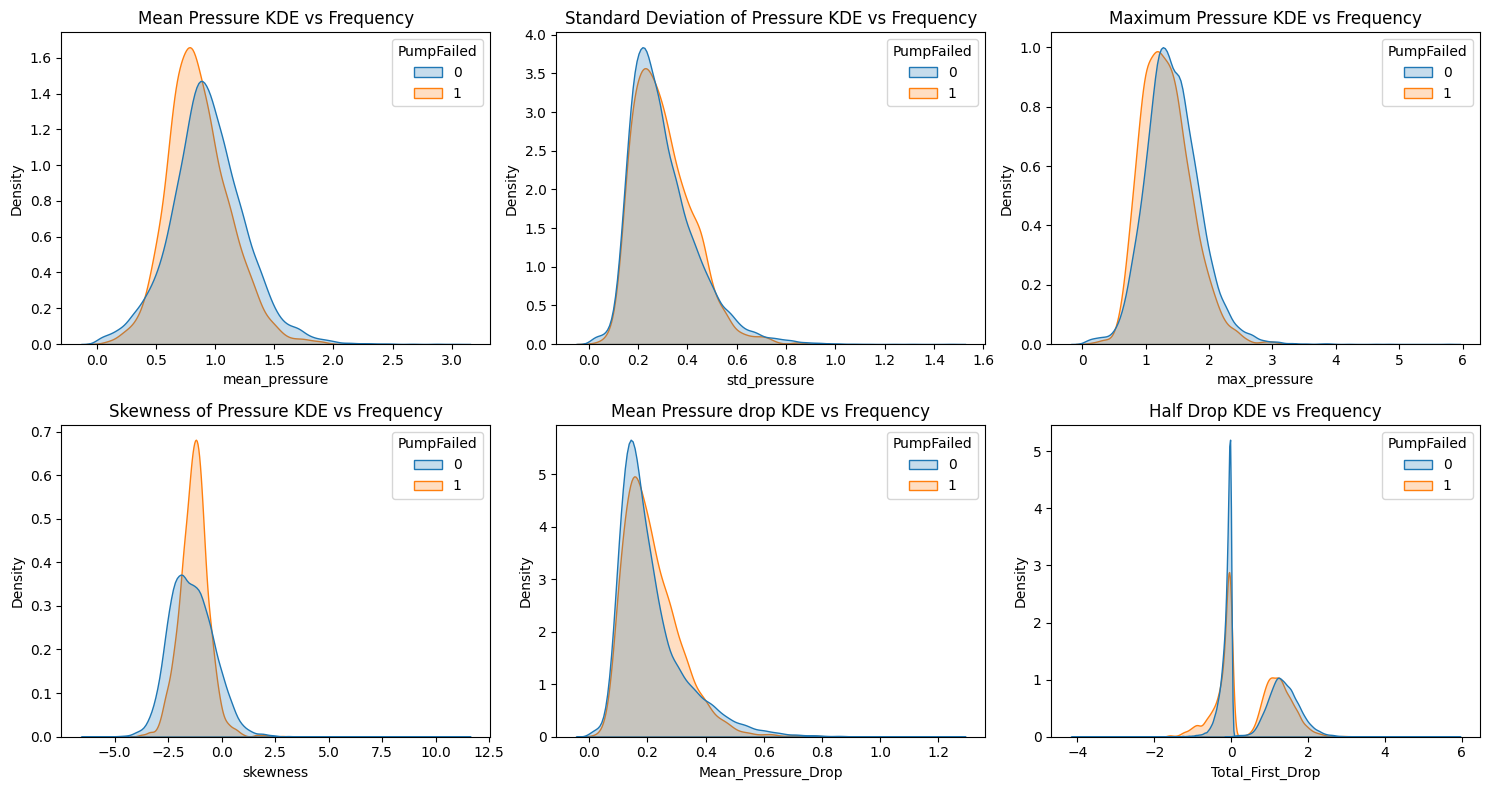

In [68]:
# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot Mean Pressure KDE against Frequency
sns.kdeplot(data=labels, x='mean_pressure', hue='PumpFailed', fill=True, common_norm=False, ax=axes[0, 0])
axes[0, 0].set_title('Mean Pressure KDE vs Frequency')

# Plot Standard Deviation of Pressure KDE against Frequency
sns.kdeplot(data=labels, x='std_pressure', hue='PumpFailed', fill=True, common_norm=False, ax=axes[0, 1])
axes[0, 1].set_title('Standard Deviation of Pressure KDE vs Frequency')

# Plot Maximum Pressure KDE against Frequency
sns.kdeplot(data=labels, x='max_pressure', hue='PumpFailed', fill=True, common_norm=False, ax=axes[0, 2])
axes[0, 2].set_title('Maximum Pressure KDE vs Frequency')

# Plot Skewness of Pressure KDE against Frequency
sns.kdeplot(data=labels, x='skewness', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 0])
axes[1, 0].set_title('Skewness of Pressure KDE vs Frequency')

# Plot Mean pressure drop of Pressure KDE against Frequency
sns.kdeplot(data=labels, x='Mean_Pressure_Drop', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 1])
axes[1, 1].set_title('Mean Pressure drop KDE vs Frequency')

# Plot Total First Drop KDE against Frequency
sns.kdeplot(data=labels, x='Total_First_Drop', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 2])
axes[1, 2].set_title('Total First Drop KDE vs Frequency')

# Plot Half Drop KDE against Frequency
sns.kdeplot(data=labels, x='half_drop', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 2])
axes[1, 2].set_title('Half Drop KDE vs Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [70]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17904 entries, 0 to 17903
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PumpFailed          17904 non-null  int32  
 1   SlowStart           17904 non-null  object 
 2   SlowEnd             17904 non-null  object 
 3   cycle_code          17904 non-null  object 
 4   mean_pressure       17842 non-null  float64
 5   std_pressure        17842 non-null  float64
 6   max_pressure        17842 non-null  float64
 7   skewness            17841 non-null  float64
 8   kurtosis            17838 non-null  float64
 9   variance            17842 non-null  float64
 10  measurement_count   17842 non-null  float64
 11  Mean_Pressure_Drop  17842 non-null  float64
 12  First_Drop_length   17842 non-null  float64
 13  Total_First_Drop    17842 non-null  float64
 14  half_drop           17842 non-null  float64
dtypes: float64(11), int32(1), object(3)
memory usage: 2.0

In [72]:
labels.dropna(inplace=True)

In [73]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17838 entries, 0 to 17903
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PumpFailed          17838 non-null  int32  
 1   SlowStart           17838 non-null  object 
 2   SlowEnd             17838 non-null  object 
 3   cycle_code          17838 non-null  object 
 4   mean_pressure       17838 non-null  float64
 5   std_pressure        17838 non-null  float64
 6   max_pressure        17838 non-null  float64
 7   skewness            17838 non-null  float64
 8   kurtosis            17838 non-null  float64
 9   variance            17838 non-null  float64
 10  measurement_count   17838 non-null  float64
 11  Mean_Pressure_Drop  17838 non-null  float64
 12  First_Drop_length   17838 non-null  float64
 13  Total_First_Drop    17838 non-null  float64
 14  half_drop           17838 non-null  float64
dtypes: float64(11), int32(1), object(3)
memory usage: 2.1+ MB


In [74]:
from xgboost import XGBClassifier # a light and often very effective model

In [75]:
#OHE the categorical variables SlowStart and SlowEnd
labels = pd.get_dummies(labels, columns=['SlowStart', 'SlowEnd'])

In [80]:
labels = labels.loc[:, ~labels.columns.duplicated()]

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
X = labels.drop(columns=['PumpFailed', 'cycle_code'])
y = labels['PumpFailed']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Standardize your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
# To address the class imbalance we will use SMOTE to create new instances of the minority class (when the pump failed)
from imblearn.over_sampling import SMOTE

#Apply smote
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [85]:
model, recall, precision, f1, auc_roc = eval_model(RandomForestClassifier(random_state=1), X_resampled, X_test, y_resampled, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

The model used: RandomForestClassifier(random_state=1)
Recall: 0.68
Precision: 0.48
F1 Score: 0.56
AUC-ROC Score: 0.89


In [86]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

               Feature  Importance
4             kurtosis    0.118439
9     Total_First_Drop    0.097396
3             skewness    0.095766
6    measurement_count    0.085741
0        mean_pressure    0.081718
7   Mean_Pressure_Drop    0.077532
5             variance    0.077043
2         max_pressure    0.074828
10           half_drop    0.072617
1         std_pressure    0.072335
8    First_Drop_length    0.072252
13       SlowEnd_False    0.023963
14        SlowEnd_True    0.022599
11     SlowStart_False    0.014987
12      SlowStart_True    0.012784


We can see that kurtosis is the best predictor (outliers in the distribution) with the SlowStart and SlowEnd labels being poor predictors.

In [87]:
model, recall, precision, f1, auc_roc = eval_model(XGBClassifier(), X_resampled, X_test, y_resampled, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

The model used: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Recall: 0.65
Precision: 0.46
F1 Score: 0.54
AUC-ROC Score: 0.89


In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [89]:
def train_score_model(model, X_train, X_test, y_train, y_test):
    '''
    Split the data, train the model specified and return score metrics

    Parameters:
    - X_test, X_train: features from the dataset
    - y_train, y_test: PumpFailed target variable

    Returns:
    - accuracy, , recall, F1, classification_report, roc_auc, cross_val_accuracy, cross_val_roc_auc
    - plots AUC_ROC Curve, Precision_Recall Curve
    '''
    
   
    #Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Performance scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,-1])
    classification_rep = classification_report(y_test, y_pred, zero_division=0)

    #Cross-val scores
    cv_score_all = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_score_all)
    cv_roc_auc_all = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    cv_roc_auc = np.mean(cv_roc_auc_all)

    print(f'Accuracy: {accuracy}')
    print(f'Recall score: {recall}')
    print(f'F1 score: {f1}')
    print(f'Classification report: {classification_rep}')
    print(f'ROC_AUC score: {roc_auc}')
    print(f'Cross-validation score: {cv_score}')
    print(f'Cross-validation ROC AUC score: {cv_roc_auc}')

    #Plotting the AUC-ROC
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title('ROC Curve')
    plt.show()

    #Plotting Precision_Recall
    prec, recall, _ = precision_recall_curve(y_test, y_proba)
    PrecisionRecallDisplay(precision = prec, recall = recall).plot()
    plt.title('Precision-Recall Curve')
    plt.show()

    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred,)
    sns.heatmap(cm, annot=True,  xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, f1, roc_auc, classification_rep, cv_score, cv_roc_auc


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8733183856502242
Recall score: 0.6462450592885376
F1 score: 0.5365053322395406
Classification report:               precision    recall  f1-score   support

           0       0.95      0.90      0.93      3954
           1       0.46      0.65      0.54       506

    accuracy                           0.87      4460
   macro avg       0.71      0.77      0.73      4460
weighted avg       0.90      0.87      0.88      4460

ROC_AUC score: 0.8869039407734399
Cross-validation score: 0.9127146136545641
Cross-validation ROC AUC score: 0.8676123608907569


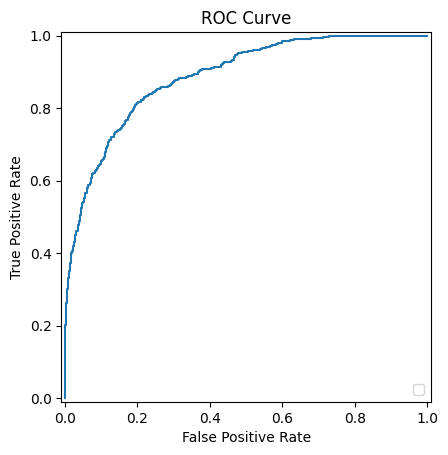

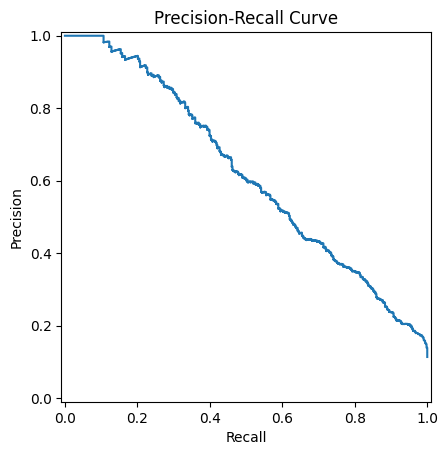

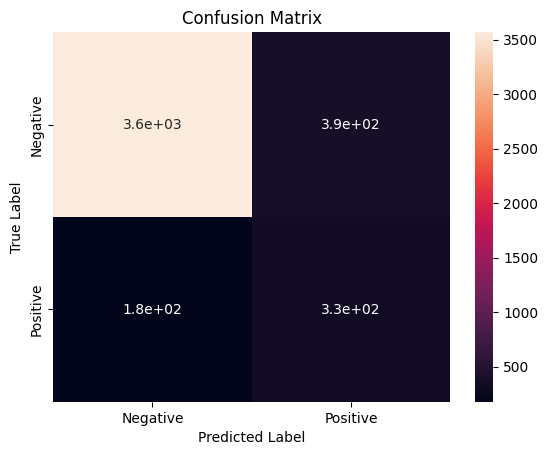

(0.8733183856502242,
 0.5365053322395406,
 0.8869039407734399,
 '              precision    recall  f1-score   support\n\n           0       0.95      0.90      0.93      3954\n           1       0.46      0.65      0.54       506\n\n    accuracy                           0.87      4460\n   macro avg       0.71      0.77      0.73      4460\nweighted avg       0.90      0.87      0.88      4460\n',
 0.9127146136545641,
 0.8676123608907569)

In [90]:
train_score_model(XGBClassifier(), X_resampled, X_test, y_resampled, y_test)